In [4]:
#Import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
import warnings

In [5]:
import datetime

#### The BTC-USD data comes from yahoo finance source
* The data has 367 rows and 7 columns: the columns are
* Open - for the opening price for the day
* High - for the highest price during the day
* Low - for the lowest price during the day
* Close - for the closing price for the day
* Adj Close - for the adjusted closing price
* Volume - for transaction volume.

In [6]:
#load the data
data = pd.read_csv('../data/BTC-USD.csv')

In [5]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-10-11,54734.125000,57793.039063,54519.765625,57484.789063,57484.789063,42637331698
1,2021-10-12,57526.832031,57627.878906,54477.972656,56041.058594,56041.058594,41083758949
2,2021-10-13,56038.257813,57688.660156,54370.972656,57401.097656,57401.097656,41684252783
3,2021-10-14,57372.832031,58478.734375,56957.074219,57321.523438,57321.523438,36615791366
4,2021-10-15,57345.902344,62757.128906,56868.144531,61593.949219,61593.949219,51780081801


In [6]:
#list of columns
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
Date         366 non-null object
Open         366 non-null float64
High         366 non-null float64
Low          366 non-null float64
Close        366 non-null float64
Adj Close    366 non-null float64
Volume       366 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 20.1+ KB


#### Statistical description

In [8]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,366.000000,366.000000,366.000000,366.000000,366.000000,3.660000e+02
mean,36907.834129,37670.420754,35968.476216,36798.452922,36798.452922,3.094423e+10
std,13900.737769,14189.795472,13558.877330,13884.573587,13884.573587,9.658349e+09
min,18534.650391,19134.732422,17708.623047,18547.400391,18547.400391,1.373656e+10
25%,22584.017578,22994.634766,21623.773926,22508.751465,22508.751465,2.464335e+10
50%,38450.746094,39396.177735,37633.261719,38425.681640,38425.681640,3.008298e+10
75%,46268.938476,47086.675781,45351.858399,46126.001953,46126.001953,3.588560e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,8.419661e+10


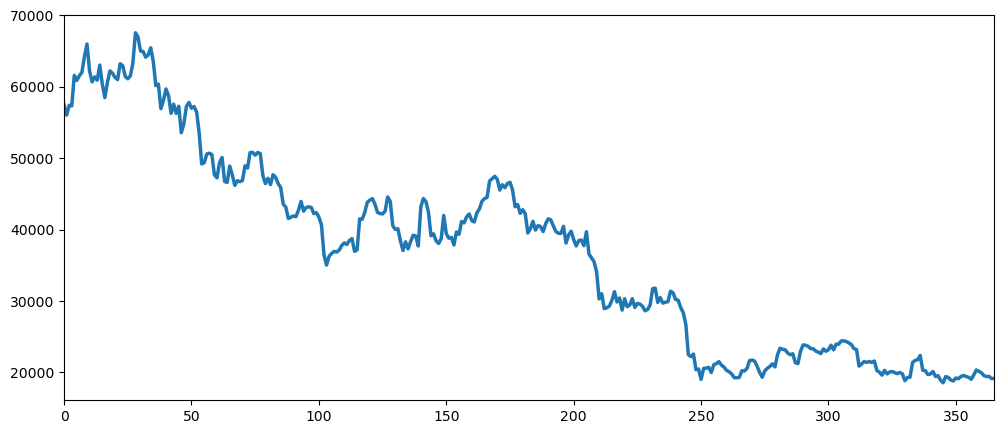

In [19]:
data_adj = data['Adj Close']
data_adj.plot(lw=2.5, figsize=(12, 5))
plt.show()

It looks like the USD value of Bitcoin has been steady during the first half of 2021, but started to oscillate and steeply went downward from around November.

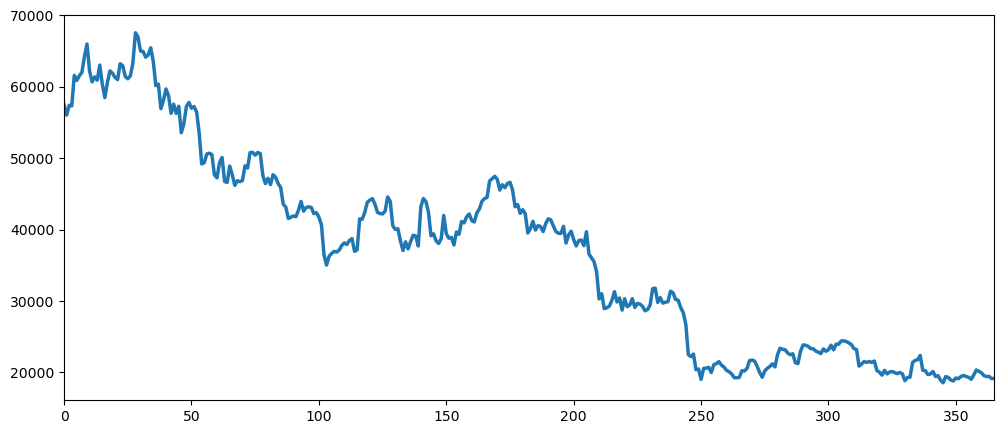

In [16]:
#btc_adj = data['Adj Close'].loc['2021-10-11':'2021-12-31']
btc_recent= data['Adj Close']
btc_recent.plot(lw=2.5, figsize=(12, 5))


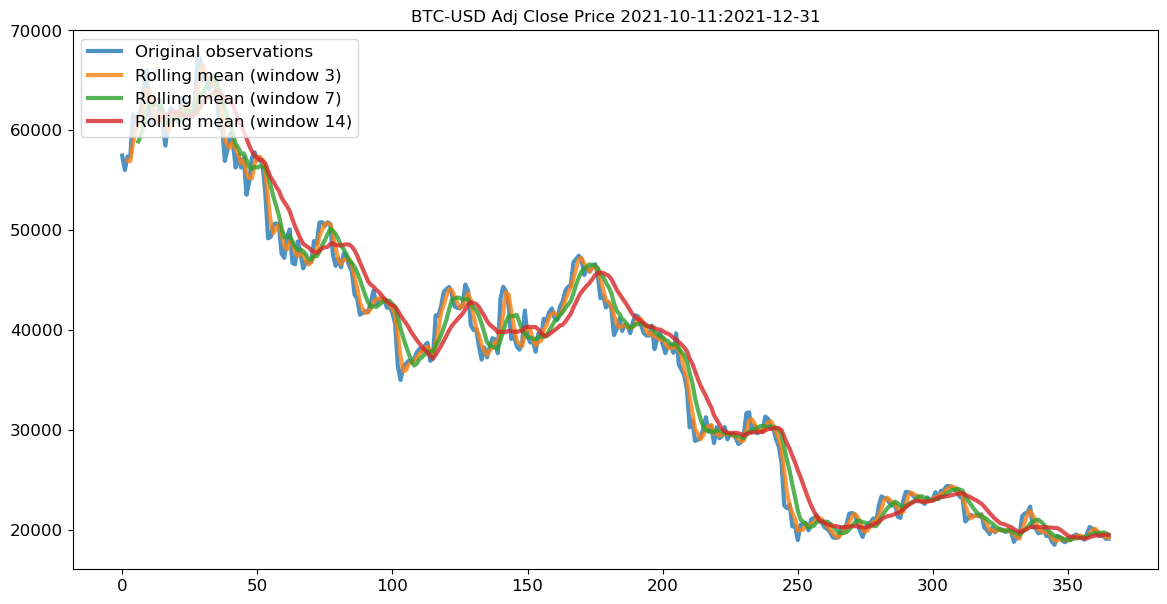

In [31]:
#btc_recent = btc_adj.loc['2021-10-11':'2022-10-11']
rroll_d3 = btc_recent.rolling(window=3).mean()
rroll_d7 = btc_recent.rolling(window=7).mean()
rroll_d14 = btc_recent.rolling(window=14).mean()
plt.figure(figsize=(14, 7))
plt.plot(btc_recent.index, btc_recent, lw=3, alpha=0.8,label='Original observations')
plt.plot(btc_recent.index, rroll_d3, lw=3, alpha=0.8,label='Rolling mean (window 3)')
plt.plot(btc_recent.index, rroll_d7, lw=3, alpha=0.8,label='Rolling mean (window 7)')
plt.plot(btc_recent.index, rroll_d14, lw=3, alpha=0.8,label='Rolling mean (window 14)')
plt.title('BTC-USD Adj Close Price 2021-10-11:2021-10-11')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

Compared to the original observation, which is plotted with a blue line, we can see the curve of the lines get smoother as window sizes get bigger.

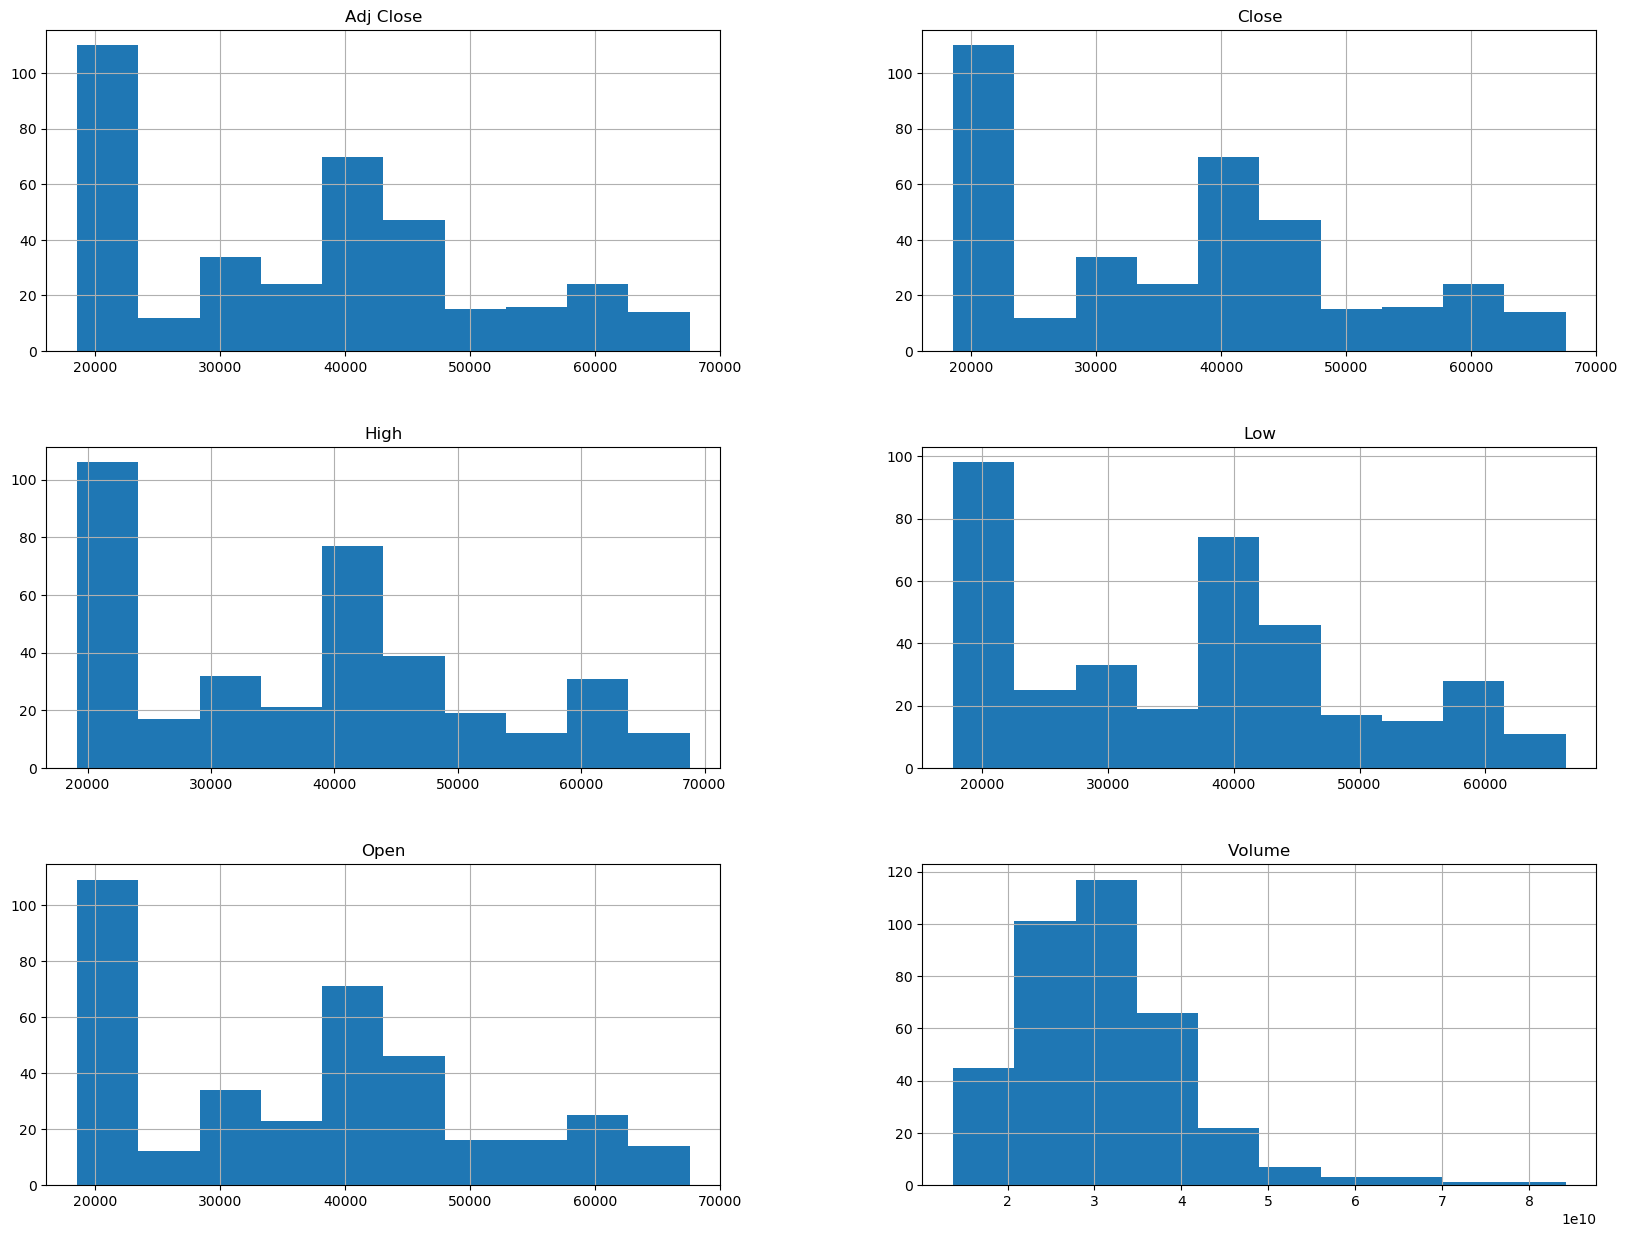

In [18]:
num_feats = list(data.select_dtypes(include=['int64', 'float64', 'int32']).columns)
data[num_feats].hist(figsize=(20,15));

The above outputs of a histogram plot shows the distribution of values within each column's series. These functions are also lightly used because of displaying small amounts of BTC data.

#### Moving average is in a trading strategy

In [17]:
short_window = 10
mid_window = 50
signals = pd.DataFrame(index=btc_recent.index)
signals['signal'] = 0.0
roll_d10 = btc_recent.rolling(window=short_window).mean()
roll_d50 = btc_recent.rolling(window=mid_window).mean()
signals['short_mavg'] = roll_d10
signals['mid_mavg'] = roll_d50
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['mid_mavg'][short_window:], 1.0, 0.0)
signals['positions'] = signals['signal'].diff()

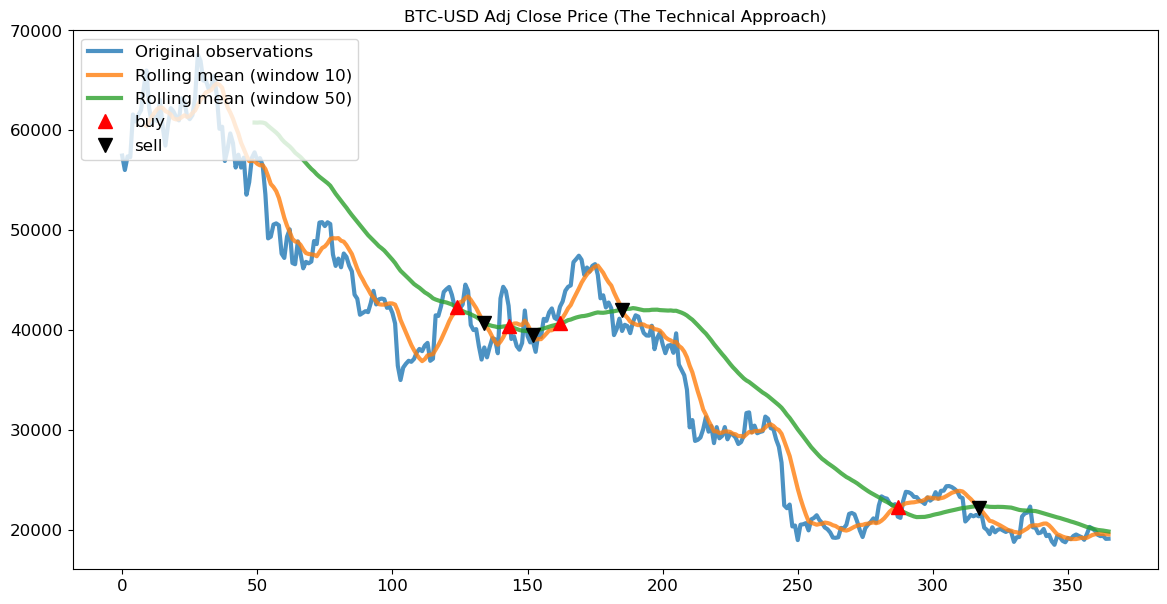

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(btc_recent.index, btc_recent, lw=3, alpha=0.8,label='Original observations')
plt.plot(btc_recent.index, roll_d10, lw=3, alpha=0.8,label='Rolling mean (window 10)')
plt.plot(btc_recent.index, roll_d50, lw=3, alpha=0.8,label='Rolling mean (window 50)')
plt.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='r', label='buy')
         
plt.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k', label='sell')
plt.title('BTC-USD Adj Close Price (The Technical Approach)')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

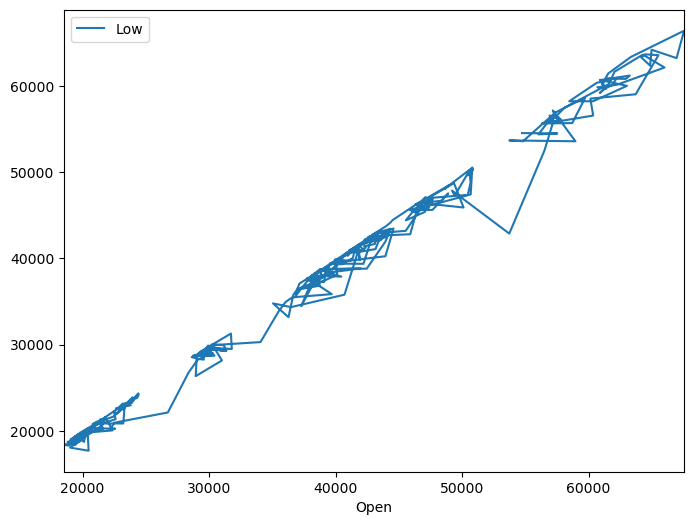

In [14]:
data.plot.line(x='Open', y='Low', figsize=(8,6))

#### Plot scatter for columns Open and Close

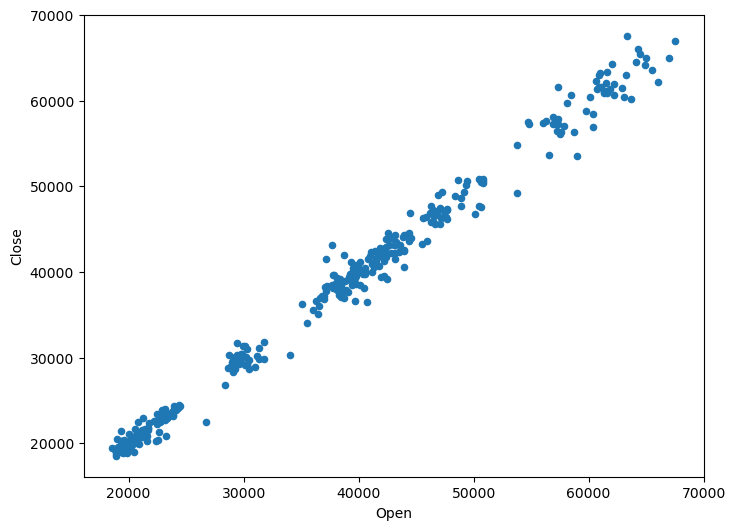

In [11]:
data.plot.scatter(x='Open', y='Close', figsize=(8,6))

#### Box plot

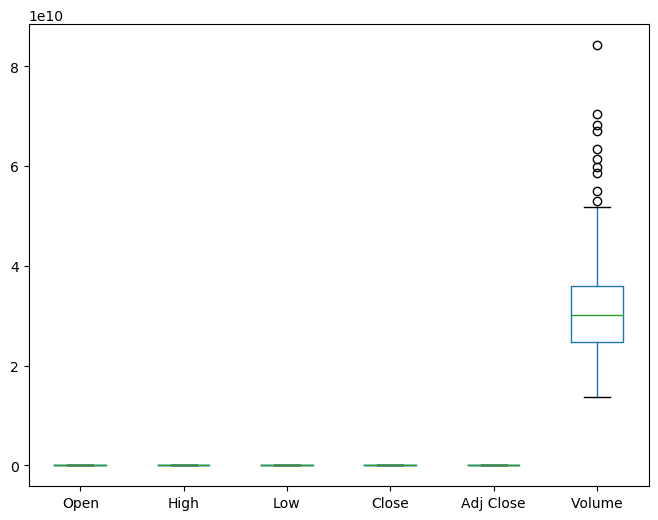

In [12]:
data.plot.box(figsize=(8,6))

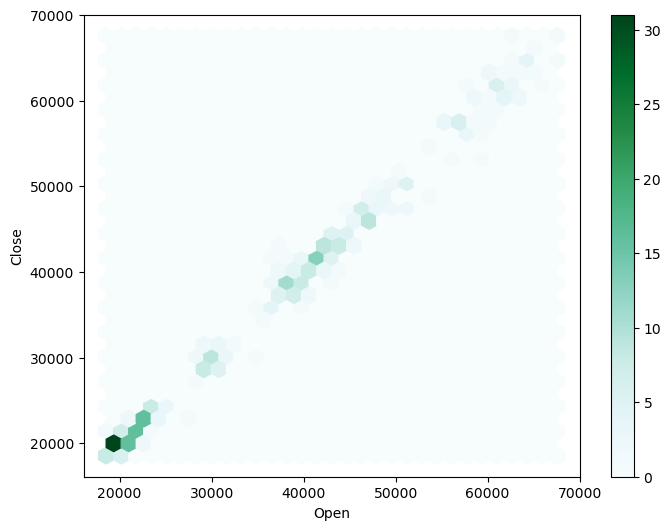

In [13]:
data.plot.hexbin(x='Open', y='Close',gridsize=30, figsize=(8,6))

#### Plot Kernel Density Chart 

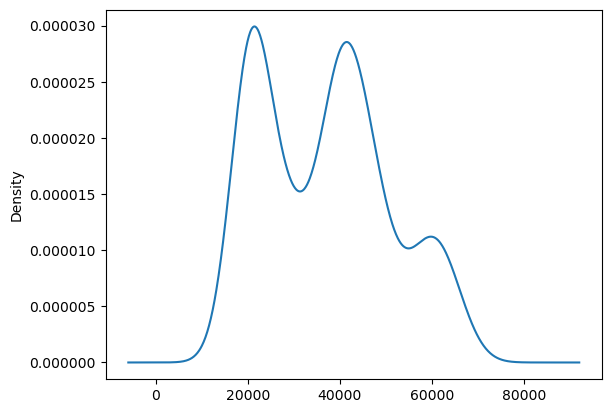

In [14]:
data["Open"].plot.kde()

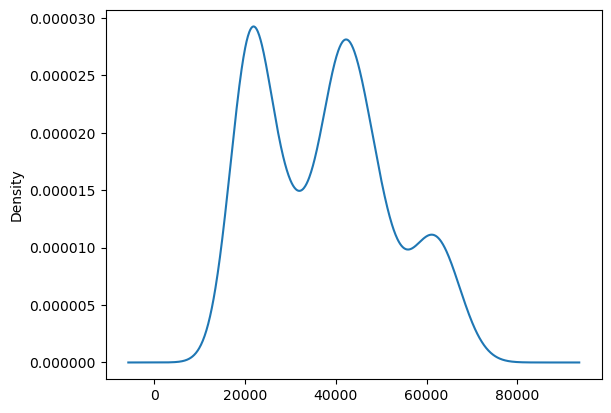

In [15]:
data["High"].plot.kde()

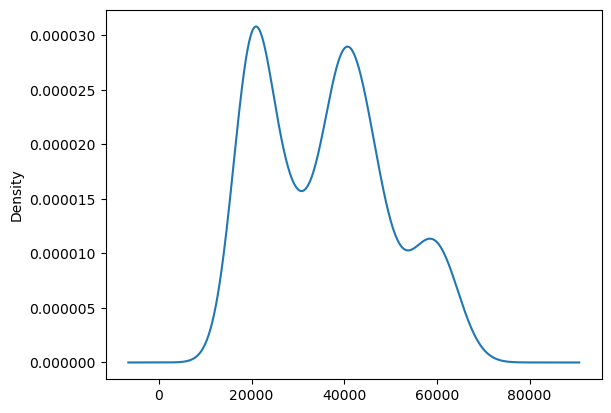

In [16]:
data["Low"].plot.kde()

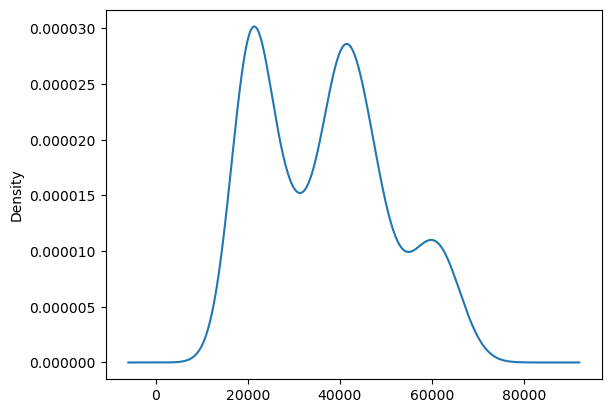

In [17]:
data["Close"].plot.kde()